In [2]:
MY_HOME_ABS_PATH = "/root/co2-flux-hourly-gpp-modeling/"

import os
import sys
import warnings
warnings.filterwarnings("ignore")
import copy
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from pytorch_forecasting import BaseModel, MAE
from pytorch_forecasting.metrics.point import RMSE
from pytorch_forecasting.data.encoders import NaNLabelEncoder

from sklearn.metrics import r2_score
from timeit import default_timer
from datetime import datetime
import gc
import pickle
import multiprocessing as mp

# Load locale custome modules
#os.chdir(MY_HOME_ABS_PATH)
sys.path.append(f'{MY_HOME_ABS_PATH}/.cred')
sys.path.append(f'{MY_HOME_ABS_PATH}/code/src/tools')
sys.path.append(os.path.abspath(f"{MY_HOME_ABS_PATH}/code/src/tools"))
  
from CloudIO.AzStorageClient import AzStorageClient
from data_pipeline_lib import *
from model_pipeline_lib import *

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pl.seed_everything(42)


# Print GPUs available
if torch.cuda.is_available():
    device_count = torch.cuda.device_count()
    print(f"Number of available GPUs: {device_count}")
else:
    print("GPU is not available on this system.")

# Download full data
root_dir  = MY_HOME_ABS_PATH
tmp_dir   = root_dir + os.sep + '.tmp'
model_dir = root_dir + os.sep + 'data' + os.sep + 'models'

container = "all-sites-data"
#blob_name = "tft-full_2010_2015_v_slim-features-v1_raw.parquet"
blob_name = "full_2010_2015_v_mvp_raw.parquet"
local_file = tmp_dir + os.sep + blob_name

data_df = get_raw_datasets(container, blob_name)

# Define experiment
exp_name = "5YrTrain_3DEncode_SmallNetwork_SlimFeatures_NoGPP"

# Experiment constants
VAL_INDEX  = 3
TEST_INDEX = 4
SUBSET_LEN = 24*365*5 # 1 year
ENCODER_LEN = 24*3   # 3 days
print(f"Training timestemp length = {SUBSET_LEN}.")

# Create model result directory
experiment_ts = datetime.now().strftime("%y%m%d_%H%M")
exp_fname = f"tft_model_{exp_name}_{experiment_ts}"
exp_model_dir = model_dir + os.sep + exp_fname
if not (os.path.exists(exp_model_dir)):
    os.makedirs(exp_model_dir)
print(f"Experiment logs saved to {exp_model_dir}.")


def setup_tsdataset_nogpp(train_df, val_df, test_df, min_encoder_len):
    # create training and validation TS dataset 
    training = TimeSeriesDataSet(
      train_df, # <------ no longer subsetting, option 1 split can use entire train site sequence
      time_idx="timestep_idx_global",
      target="GPP_NT_VUT_REF",
      group_ids=["site_id"],
      allow_missing_timesteps=False, # <---- turned on bc some rows are removed.
      min_encoder_length=min_encoder_len,
      max_encoder_length=min_encoder_len,
      min_prediction_length=1,
      max_prediction_length=1,
      static_categoricals=["koppen_main"],
      static_reals=[],
      time_varying_known_categoricals=["month", "hour"],
      time_varying_known_reals=['TA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'VPD_ERA', 'P_ERA', 'PA_ERA',
                                'EVI', 'NDVI', 'NIRv', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7'],
      time_varying_unknown_categoricals=[], 
      time_varying_unknown_reals=[],
      target_normalizer=None,
      categorical_encoders={'koppen_main': NaNLabelEncoder(add_nan=True),
                            },
      add_relative_time_idx=True,
      add_target_scales=False, # <------- turned off
      add_encoder_length=False, # <------- turned off
    )

    validation = TimeSeriesDataSet.from_dataset(training, val_df, predict=False, stop_randomization=True)
    
    if test_df is not None:
        testing = TimeSeriesDataSet.from_dataset(training, test_df, predict=False, stop_randomization=True)
    else:
        testing = None

    return (training, validation, testing)


# setup datasets data
train_df, val_df, _ = get_splited_datasets(data_df, VAL_INDEX, TEST_INDEX)
train_df, val_df, _ = subset_data(train_df, val_df, None, SUBSET_LEN)
training, validation, _ = setup_tsdataset_nogpp(train_df, val_df, None, ENCODER_LEN)

2023-03-27 01:44:36.448338: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-27 01:44:36.450604: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-27 01:44:36.498312: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-27 01:44:36.499037: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-27 01:44:37.230569: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

Number of available GPUs: 4
Data size: (4862712, 51)
Data Columns: Index(['GPP_NT_VUT_REF', 'site_id', 'timestep_idx_local',
       'timestep_idx_global', 'datetime', 'date', 'year', 'month', 'day',
       'hour', 'TA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'VPD_ERA', 'P_ERA',
       'PA_ERA', 'EVI', 'NDVI', 'NIRv', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6',
       'b7', 'IGBP', 'lat', 'long', 'koppen_sub', 'koppen_main', 'c3c4',
       'c4_percent', 'BESS-PAR', 'BESS-PARdiff', 'BESS-RSDN', 'CSIF-SIFdaily',
       'PET', 'Ts', 'ESACCI-sm', 'MODIS_LC', 'NDWI', 'Percent_Snow', 'Fpar',
       'Lai', 'LST_Day', 'LST_Night', 'MODIS_IGBP', 'MODIS_PFT',
       'gap_flag_hour', 'gap_flag_month'],
      dtype='object')
NA count: 0
Training timestemp length = 43800.
Experiment logs saved to /root/co2-flux-hourly-gpp-modeling/data/models/tft_model_5YrTrain_3DEncode_SmallNetwork_SlimFeatures_NoGPP_230327_0145.
Subest length: 43800 timesteps for each sites
Subset num train timesteps: 2579424
Subset num val timest

In [8]:
# create dataloaders for model
# ref: https://pytorch-lightning.readthedocs.io/en/stable/guides/speed.html#dataloaders
batch_size = 256  # set this between 32 to 128
cpu_count = os.cpu_count()
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=cpu_count, pin_memory=True)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=cpu_count, pin_memory=False)

In [9]:
# Create TFT model from dataset
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.001,
    hidden_size=32,  # most important hyperparameter apart from learning rate
    attention_head_size=2, # Set to up to 4 for large datasets
    dropout=0.3, # Between 0.1 and 0.3 are good values
    hidden_continuous_size=32,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    logging_metrics=nn.ModuleList([MAE(), RMSE()]),
    reduce_on_plateau_patience=3, # reduce learning rate if no improvement in validation loss after x epochs
    optimizer="adam"
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Number of parameters in network: 226.2k


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
Finding best initial lr: 100%|██████████| 100/100 [00:21<00:00,  4.64it/s]
Restoring states from the checkpoint path at /root/co2-flux-hourly-gpp-modeling/.lr_find_d2e1479c-2be7-473d-a78a-22a81d03442e.ckpt
Restored all states from the checkpoint file at /root/co2-flux-hourly-gpp-modeling/.lr_find_d2e1479c-2be7-473d-a78a-22a81d03442e.ckpt


suggested learning rate: 0.018803015465431967


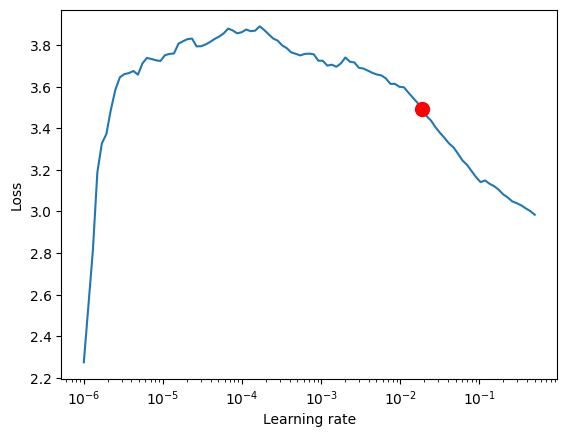

In [10]:
# find optimal learning rate
trainer = pl.Trainer(
    gpus=1,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    #gradient_clip_val=0.1,
)


res = trainer.tuner.lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=0.5,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [ ]:
# # configure network and trainer
# early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=7, mode="min",
#                                     check_finite=True, verbose=False,)
# lr_logger = LearningRateMonitor()  # log the learning rate
# logger = TensorBoardLogger(exp_model_dir)  # logging results to a tensorboard

# trainer = pl.Trainer(
#     max_epochs=25,
#     enable_model_summary=True,
#     #gradient_clip_val=2,
#     fast_dev_run=False,  # comment in to check that network or dataset has no serious bugs
#     accelerator='gpu',
#     devices="auto", 
#     callbacks=[lr_logger, early_stop_callback],
#     logger=logger,
#     strategy="ddp",
# )


# start = default_timer()
# trainer.fit(
#     tft,
#     train_dataloaders=train_dataloader,
#     val_dataloaders=val_dataloader,
# )
# train_time = default_timer() - start
# print(f"Training time: {train_time}")

# # load the best model according to the validation loss
# best_model_path = trainer.checkpoint_callback.best_model_path
# print(" Best model path: " + best_model_path)
# best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

# local_model_path = exp_model_dir + os.sep + f"model.pth"
# torch.save(best_tft.state_dict(), local_model_path)
# print(f"Saved model to {local_model_path}")

